# Bulldozer Price Prediction - Time Series Regression

## Overview  
This notebook focuses on **predicting the sale price of bulldozers** using **Machine Learning regression** techniques.  

## Dataset
The dataset comes from the **Blue Book for Bulldozers** Kaggle competition:  
 [Dataset Source](https://www.kaggle.com/competitions/bluebook-for-bulldozers/data)  

### Dataset Info
- **Historical auction data** for bulldozers sold between **1989 and 2012**  
- Features include **equipment type, year of manufacture, usage hours, location, and sale date**  
- This is a **time series regression problem** where prices depend on both **machine attributes and time-based trends**  

## Objective  
- Train a **regression model** that can **predict the sale price of a bulldozer**  
- Handle **time-based trends** and missing data  
- Optimize performance through **feature engineering & hyperparameter tuning**  

In [4]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline

## 1. Get the Train/Validation Data Ready

In [6]:
# import dataset (train and validation)
bulldozer_df = pd.read_csv("./dataset/bluebook-for-bulldozers/TrainAndValid.csv", 
                           low_memory=False, 
                           parse_dates=["saledate"])

In [7]:
bulldozer_df.saledate.head(5)

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

#### Sort DataFrame by `saledate` column

In [9]:
# Sort DataFrame by saledate
bulldozer_df.sort_values(by=["saledate"], inplace=True, ascending=True)

In [10]:
bulldozer_df.saledate.head(5)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

#### Make a copy of the original DataFrame: preserve the original data when manipulating the copy

In [12]:
#Make a copy
bulldozer_df_tmp = bulldozer_df

## 2. Feature Engineering

In [14]:
def preprocess_data(df):
    """Run few enrichmnts on top of the DataFrame(df)"""
    ### Add datetime parameters for `saledate` columns
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.day_of_week
    df["saleDayOfYear"] = df.saledate.dt.day_of_year
    
    # Remove the `saledate` attribute after have enriched the datetime attributes
    df.drop("saledate", axis=1, inplace=True)

    ### Convert String to Categories
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content): #if it is not numeric then assign it as "category"
            df[label] = content.astype("category").cat.as_ordered()
    return df

In [15]:
preprocess_data(bulldozer_df_tmp)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,D38E,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2064,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,337G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,12G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


#### Save preprocessed data

In [17]:
## Saved to parquet to preserve the Pandas Dtype specially the "category" type
bulldozer_df_tmp.to_parquet("dataset/bluebook-for-bulldozers/preprocessed_train.parquet", 
                        index=False)
bulldozer_df_tmp = pd.read_parquet("dataset/bluebook-for-bulldozers/preprocessed_train.parquet")

len(bulldozer_df_tmp)    

412698

## Split data into train/validations set

In [19]:
np.random.seed(42)
## Split data into train/validations set
bulldozer_df_val = bulldozer_df_tmp[bulldozer_df_tmp["saleYear"]==2012]
bulldozer_df_train = bulldozer_df_tmp[bulldozer_df_tmp["saleYear"]!=2012]

# split Train data into X & y
X_train = bulldozer_df_train.drop("SalePrice", axis=1)
y_train = bulldozer_df_train["SalePrice"]

# split Validation data into X & y
X_val = bulldozer_df_val.drop("SalePrice", axis=1)
y_val = bulldozer_df_val["SalePrice"]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 56), (401125,), (11573, 56), (11573,))

### Fill missing values

In [21]:
## function to fill missing values for numeric and non numeric data (and categorise the non nuemeric)
def fill_missing_categorise_values(df):
    """Check for missing values dependning on the dtype and:
    * Numerical: fill missing valyes with median;
    * Non Numerical: fill missing values with categories."""
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content): 
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content) #informs if the data was missing
                df[label] = content.fillna(content.median()) #fills missing value with median
        else:
            if pd.isnull(content).sum():
                df[label] = pd.Categorical(content).codes + 1
            else:
                df[label] = pd.Categorical(content).codes + 1
                df[label+"_is_missing"] = False

In [22]:
## Check again for numeric columns if any still has missing values
def check_missing_values(df):
    """Check a DataFrame for missing values"""
    labels_missing_values = []
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content): 
            if pd.isnull(content).sum():
                labels_missing_values.append(label)
        else:
            if pd.isnull(content).sum():
                labels_missing_values.append(label)
    if labels_missing_values:
        return(labels_missing_values)
    else:
        return("No missing values")

In [23]:
## treat train data
fill_missing_categorise_values(X_train)

## treat validtion data
fill_missing_categorise_values(X_val)

In [24]:
check_missing_values(X_train), check_missing_values(X_val)
set(X_train.columns) ^ set(X_val.columns)

{'auctioneerID_is_missing'}

In [25]:
# Add the missing column to X_val to ensure no errors when fitting the data (due to differences between X_train and X-val cols)
X_val["auctioneerID_is_missing"] = False
# re-arrange X_val columns to match with X_train
X_val = X_val[X_train.columns]


## 3. Modelling

In [27]:
%%time
### Build a Machine Learning model - model driven EDA
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42)

# model.fit(X_train, 
#           y_train)

#score the model
# model.score(X_val, 
#             y_val)

CPU times: total: 531 ms
Wall time: 2.98 s


## 4. Evaluate using RMSLE (root mean squared log error)

In [29]:
## builing and evaluate function
from sklearn.metrics import root_mean_squared_log_error, r2_score

def rmsle(y_true, y_pred):
    """Calculate RMSLE (root mean squared log error) using predictions and true labels"""
    return root_mean_squared_log_error(y_true, y_pred)

def show_scores(model):
    """run predicts on train and validation set on top of different models"""
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Train RMSLE": rmsle(y_train, train_preds),
              "Val RMSLE": rmsle(y_val, val_preds),
              "Train R2Score": r2_score(y_train, train_preds),
              "Val R2Score": r2_score(y_val, val_preds)
             }
    return scores
    

In [30]:
#### Testing model on a subset 10k
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

In [31]:
%%time
model.fit(X_train,y_train)

show_scores(model)

CPU times: total: 1min 59s
Wall time: 19 s


{'Train RMSLE': 0.2577945385449973,
 'Val RMSLE': 0.2940478268776478,
 'Train R2Score': 0.8606063694177069,
 'Val R2Score': 0.8325672058427591}

### 5. Hyperparameter tuning with `GridSearchCV`

In [33]:
%%time
from sklearn.model_selection import GridSearchCV
gs_cv_grid = {"n_estimators": np.arange(50, 300, 100),
              "max_depth": [None, np.arange(5, 30, 5)],
              "max_features": ["sqrt"],
              "min_samples_split": np.arange(2, 10, 2),
              "min_samples_leaf": np.arange(1, 4, 1) ,
              "max_samples": [1000]
             }

gs_cv_model = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), 
                           gs_cv_grid,
                           n_jobs=1,
                           cv=2,
                           verbose=False
                          )

# gs_cv_model.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [34]:
#gs_cv_model.best_params_
# {'max_depth': None,
#  'max_features': 'sqrt',
#  'max_samples': 1000,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 250}

In [35]:
%%time
rf_model = RandomForestRegressor(max_depth=None,
                                 max_features="sqrt",
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 n_estimators=500,
                                 random_state=42,
                                 n_jobs=-1)

# rf_model.fit(X_train, y_train)
# show_scores(rf_model)

CPU times: total: 0 ns
Wall time: 0 ns


## Get Test Data Ready

In [37]:
##import test data
df_test = pd.read_csv("dataset/bluebook-for-bulldozers/Test.csv",
                     parse_dates=["saledate"],
                     low_memory=False)

#sort by saledate in ascending order
df_test.sort_values(by=["saledate"], inplace=True, ascending=True)

#Make a copy
df_test_tmp = df_test

### Preprocess `df_test_tmp` dataframe

In [39]:
## preprocess test data
preprocess_data(df_test_tmp)

## treat test data
fill_missing_categorise_values(df_test_tmp)

## compare X_train columns vs test data
set(df_test_tmp) ^ set(X_train)

## add missing col to test data
df_test_tmp["auctioneerID_is_missing"] = False

##ensure df_test data has same cols as X_train and same order
df_test_tmp = df_test_tmp[X_train.columns]

In [40]:
#check for missing values
#df_test_tmp.isna().sum()

#check if all columns are numeric
#df_test_tmp.info()

## compare X_train columns vs test data
set(df_test_tmp) ^ set(X_train)

set()

In [41]:
np.random.seed(42)
#create X_test
X_test = df_test_tmp

## Predictions

In [43]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(max_depth=None,
                                 max_features="sqrt",
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 n_estimators=250,
                                 random_state=42,
                                 n_jobs=-1)

%%time
#fit train data
model.fit(X_train, y_train)


CPU times: total: 46.9 ms
Wall time: 41.2 ms


In [45]:
# predictions 
y_preds = model.predict(X_test)

# # convert predictions into a DataFrame with required columns
preds_df = pd.DataFrame({"SalesID": X_test["SalesID"].values, "SalePrice": y_preds})


# save file to csv to submit predictions
preds_df.to_csv("dataset/bluebook-for-bulldozers/predictions.csv", index=False)




## Feature Importance

In [146]:
# check feature_importances
feature_importances = model.feature_importances_

In [268]:
# create a DataFrame and add Importance column
feature_importances_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=["Importance"])

# filter the data to get top 20
filtered_df = feature_importances_df.nlargest(20, "Importance")

# sort the Importance values in desc order
filtered_df = filtered_df.sort_values(by="Importance", ascending=False)

In [228]:
filtered_df.value_counts

<bound method DataFrame.value_counts of                     Importance
YearMade              0.119747
fiSecondaryDesc       0.071874
ProductSize           0.069197
Enclosure             0.057501
ModelID               0.056599
fiModelDesc           0.051839
saleYear              0.049487
fiProductClassDesc    0.043819
SalesID               0.040491
MachineID             0.039337
fiModelDescriptor     0.038867
fiBaseModel           0.037365
ProductGroup          0.018476
ProductGroupDesc      0.016896
saleDayOfYear         0.016480
Coupler_System        0.016466
saleDay               0.013581
Grouser_Tracks        0.013397
state                 0.012782
Hydraulics_Flow       0.012466
Tire_Size             0.011466
fiModelSeries         0.010840
saleMonth             0.010294>

### Plotting feature importances_

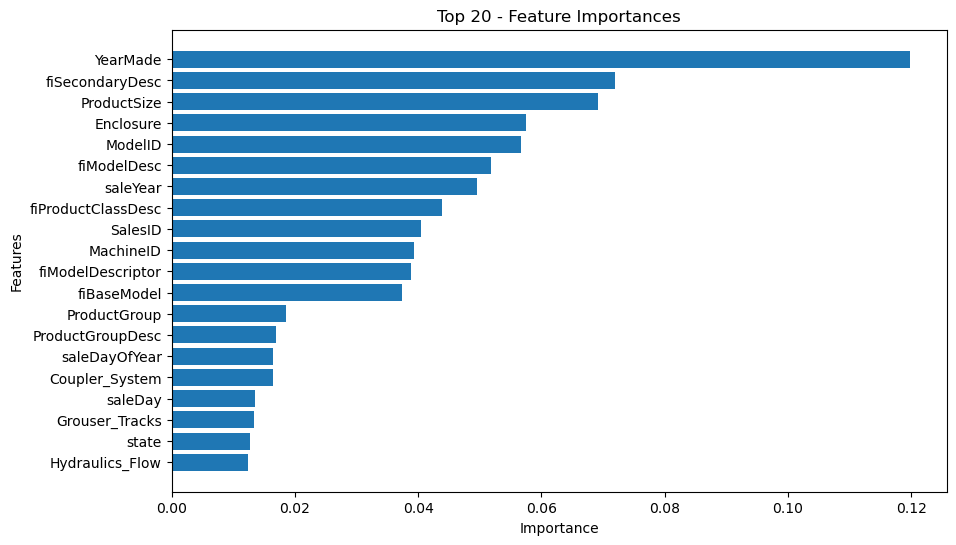

In [306]:
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(y=filtered_df.index, width=filtered_df["Importance"].values)
plt.title("Top 20 - Feature Importances")
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
ax.set_xlim(0, filtered_df["Importance"].max() * 1.05)
ax.invert_yaxis()
